In [210]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import Ridge, Lasso

import xgboost as xgb
from xgboost import plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance

from catboost import CatBoostRegressor

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [2]:
# 한글 폰트 깨짐 방지
import warnings
import platform
from matplotlib import font_manager, rc
## 운영체제별 글꼴 세팅
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    font_name = 'AppleGothic'
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    font_name = font_manager.FontProperties(fname="/usr/share/fonts/nanumfont/NanumGothic.ttf")
    rc('font', family="NanumGothic")
warnings.simplefilter(action='ignore')

In [35]:
# 출력 다 보여주기
pd.set_option('display.max_rows', 100)

### Total data 불러오기

In [394]:
df = pd.read_csv('C:\\Users\SAMSUNG\Desktop\SSAC\머신러닝\메인프로젝트\df/total_data(성비더함).csv')
df.columns

Index(['jur_stn', 'year', 'child', 'house', 'report_sx_total', 'vio_cnt',
       'mur_rob_cnt', 'car_cnt', 'popu_합계', 'for_합계', 'popu_u20', 'popu_o60',
       'for_u20', 'for_2030', 'single_합계', 'single_u20', 'single_2030',
       'single_4050', 'single_o60', 'single_f_합계', 'single_f_u20',
       'single_f_2030', 'single_f_4050', 'single_f_o60', 'popu_2050',
       'for_o40', '총범죄발생대비검거수', '절도폭력범죄발생대비검거수', '강도살인범죄발생대비검거수',
       '교통사고범죄발생대비검거수', '기초질서범죄발생대비검거수', '인구수대비검거수', '외국인인구수대비검거수', '인구수대비경찰수',
       'before_q1', 'before_q2', 'before_q3', 'before_q4', 'before_q5',
       'light_r', 'cctv_r', 'adult_r', 'bell_r', 'light_cnt', 'cctv', 'adult',
       'bell', 'ofn_10', 'ofn_20', 'ofn_340', 'ofn_5670', 'ofn_80ov', 'ofn_m',
       'ofn_w', 'ofn_unknown', 'vic_10', 'vic_20', 'vic_340', 'vic_5670',
       'vic_80ov', 'vic_m', 'vic_w', 'vic_unknown', 'case_car_man',
       'case_car_car', 'case_car_only', 'q1', 'q2', 'q3', 'q4', 'q5',
       'popu_female_합계', 'for_female_합계', 'popu_203

In [395]:
df.drop(['light_r','cctv_r','adult_r','bell_r','popu_합계','for_합계','popu_u20',
        'popu_o60','for_u20', 'for_2030','for_o40','popu_2030', 'popu_4050','for_4050', 'for_o60'], axis = 1, inplace = True)

In [396]:
df.shape

(328, 80)

In [397]:
df.corr()['q3'].sort_values(ascending = False)

q3                  1.000000
q5                  0.643191
q4                  0.538620
q2                  0.531594
q1                  0.527627
before_q5           0.309363
before_q2           0.305769
before_q1           0.285120
before_q4           0.278518
before_q3           0.276056
child               0.237613
총범죄발생대비검거수          0.193138
house               0.192864
인구수대비경찰수            0.178875
교통사고범죄발생대비검거수       0.161959
ofn_5670            0.156044
mur_rob_cnt         0.109742
ofn_unknown         0.101019
인구수대비검거수            0.075530
vic_5670            0.057130
외국인인구수대비검거수         0.056604
case_car_car        0.046044
vic_340             0.041995
기초질서범죄발생대비검거수       0.037559
절도폭력범죄발생대비검거수       0.026275
ofn_w               0.023751
for_sx_rate_u20     0.021268
ofn_80ov            0.015437
ofn_340             0.010119
vic_w               0.009769
강도살인범죄발생대비검거수       0.009329
single_f_u20        0.006844
for_female_u20      0.003845
car_cnt            -0.004321
report_sx_tota

### train_test_split

In [398]:
# 20년도는 test, 나머지는 학습용
X_train = df[(df['year'] != '2020(상반기)') & (df['year'] != '2020(하반기)')]
X_test = df[(df['year'] == '2020(상반기)') | (df['year'] == '2020(하반기)')]

In [399]:
le = LabelEncoder()

X_train['year'] = le.fit_transform(X_train['year'])
X_test['year'] = le.fit_transform(X_test['year'])

In [400]:
X_train['year'].unique()

array([0, 1, 2, 3, 4, 5])

In [401]:
y_q1 = X_train[['q1']]
y_q2 = X_train[['q2']]
y_q3 = X_train[['q3']]
y_q4 = X_train[['q4']]
y_q5 = X_train[['q5']]

X_train = X_train.drop(['q1','q2','q3','q4','q5'], axis = 1)

In [402]:
# y data train_test_split
y_q1_train = y_q1.iloc[:164]
y_q2_train = y_q2.iloc[:164]
y_q3_train = y_q3.iloc[:164]
y_q4_train = y_q4.iloc[:164]
y_q5_train = y_q5.iloc[:164]

y_q1_test = y_q1.iloc[164:]
y_q2_test = y_q2.iloc[164:]
y_q3_test = y_q3.iloc[164:]
y_q4_test = y_q4.iloc[164:]
y_q5_test = y_q5.iloc[164:]

In [403]:
X_train_q1 = X_train.iloc[:164,:]
X_test_q1 = X_train.iloc[164:,:]

X_train_q2 = X_train.iloc[:164,:]
X_test_q2 = X_train.iloc[164:,:]

X_train_q3 = X_train.iloc[:164,:]
X_test_q3 = X_train.iloc[164:,:]

X_train_q4 = X_train.iloc[:164,:]
X_test_q4 = X_train.iloc[164:,:]

X_train_q5 = X_train.iloc[:164,:]
X_test_q5 = X_train.iloc[164:,:]

In [404]:
X_train_q1.drop(['jur_stn'], axis = 1, inplace = True)
X_train_q2.drop(['jur_stn'], axis = 1, inplace = True)
X_train_q3.drop(['jur_stn'], axis = 1, inplace = True)
X_train_q4.drop(['jur_stn'], axis = 1, inplace = True)
X_train_q5.drop(['jur_stn'], axis = 1, inplace = True)

X_test_q1.drop(['jur_stn'], axis = 1, inplace = True)
X_test_q2.drop(['jur_stn'], axis = 1, inplace = True)
X_test_q3.drop(['jur_stn'], axis = 1, inplace = True)
X_test_q4.drop(['jur_stn'], axis = 1, inplace = True)
X_test_q5.drop(['jur_stn'], axis = 1, inplace = True)

### feature selection

###### R 단계적 선택법
```
q3
ofn_20 + child + 인구수대비경찰수 + 총범죄발생대비검거수 + 
    for_u20 + for_합계 + ofn_m + popu_o60 + single_합계 + single_f_2030 + 
    vic_10 + ofn_10 + case_car_man + vic_340
```

In [186]:
X_train_q3.columns

Index(['year', 'child', 'house', 'report_sx_total', 'vio_cnt', 'mur_rob_cnt',
       'car_cnt', 'single_합계', 'single_u20', 'single_2030', 'single_4050',
       'single_o60', 'single_f_합계', 'single_f_u20', 'single_f_2030',
       'single_f_4050', 'single_f_o60', 'popu_2050', '총범죄발생대비검거수',
       '절도폭력범죄발생대비검거수', '강도살인범죄발생대비검거수', '교통사고범죄발생대비검거수', '기초질서범죄발생대비검거수',
       '인구수대비검거수', '외국인인구수대비검거수', '인구수대비경찰수', 'before_q1', 'before_q2',
       'before_q3', 'before_q4', 'before_q5', 'light_cnt', 'cctv', 'adult',
       'bell', 'ofn_10', 'ofn_20', 'ofn_340', 'ofn_5670', 'ofn_80ov', 'ofn_m',
       'ofn_w', 'ofn_unknown', 'vic_10', 'vic_20', 'vic_340', 'vic_5670',
       'vic_80ov', 'vic_m', 'vic_w', 'vic_unknown', 'case_car_man',
       'case_car_car', 'case_car_only', 'popu_female_합계', 'for_female_합계',
       'popu_female_u20', 'popu_female_2030', 'popu_female_4050',
       'popu_female_o60', 'for_female_u20', 'for_female_2030',
       'for_female_4050', 'for_female_o60', 'sx_rate_합계', 'sx_r

In [187]:
df.corr().sort_values(by = 'q3',ascending = False)

,child,house,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,single_합계,single_u20,single_2030,single_4050,...,sx_rate_합계,sx_rate_u20,sx_rate_2030,sx_rate_4050,sx_rate_o60,for_sx_rate_합계,for_sx_rate_u20,for_sx_rate_2030,for_sx_rate_4050,for_sx_rate_o60
q3,0.237613,0.192864,-0.004752,-0.067422,0.109742,-0.004321,-0.141682,-0.015674,-0.149147,-0.146544,...,-0.303177,-0.144635,-0.279183,-0.279634,-0.019716,-0.166051,0.021268,-0.139687,-0.201872,-0.224196
q5,0.348918,0.198103,-0.116245,-0.251814,0.017011,0.087414,-0.258097,-0.016371,-0.194289,-0.315561,...,-0.332653,-0.019900,-0.335499,-0.404561,-0.020860,0.053652,0.209218,0.081847,-0.021735,-0.231531
q4,0.314495,0.248401,-0.026812,-0.106719,0.221653,0.163600,-0.154745,-0.053849,-0.127945,-0.189917,...,-0.211324,0.046544,-0.207724,-0.268572,0.001698,0.106323,0.259090,0.122731,0.061410,-0.145945
q2,0.287857,0.190757,-0.137661,-0.275363,-0.076175,0.043256,-0.220388,0.050969,-0.142674,-0.298293,...,-0.340554,-0.063757,-0.332329,-0.400143,-0.044527,0.055705,0.160826,0.080974,-0.019558,-0.198609
q1,0.318250,0.158334,-0.133221,-0.273450,-0.066298,0.056525,-0.238622,0.014705,-0.157823,-0.314612,...,-0.364018,-0.040216,-0.359290,-0.443279,-0.047428,0.050226,0.194796,0.076882,-0.041740,-0.238139
before_q5,0.349110,0.281162,-0.127224,-0.253853,0.068976,0.019139,-0.198843,-0.028481,-0.142417,-0.270374,...,-0.305372,-0.025159,-0.319429,-0.346462,0.024945,0.037368,0.249332,0.056493,-0.013751,-0.250973
before_q2,0.302976,0.229655,-0.147609,-0.272811,0.019042,-0.005467,-0.187995,0.011855,-0.120127,-0.271906,...,-0.277387,-0.056532,-0.278099,-0.303507,-0.005777,0.063179,0.198055,0.073277,0.029581,-0.169610
before_q1,0.336895,0.213482,-0.154230,-0.283831,-0.024275,0.004120,-0.222520,-0.004182,-0.157169,-0.298908,...,-0.296297,-0.032252,-0.296546,-0.340188,-0.016312,0.063127,0.235746,0.077830,0.004178,-0.196113
before_q4,0.298233,0.328816,-0.022525,-0.113482,0.212078,0.096184,-0.052837,-0.052229,-0.037747,-0.100581,...,-0.184154,0.058711,-0.204192,-0.200308,0.046373,0.088763,0.266136,0.093905,0.084323,-0.122320
before_q3,0.249816,0.287361,-0.040962,-0.105871,0.083989,-0.085490,-0.108460,-0.031495,-0.111410,-0.130896,...,-0.319301,-0.149165,-0.311993,-0.256863,-0.039456,-0.208313,0.023044,-0.189163,-0.193482,-0.239381


In [191]:
X_train_q3_t = X_train_q3[['ofn_5670','child','인구수대비경찰수','총범죄발생대비검거수','cctv','light_cnt','adult',
                          'ofn_m','vic_10','case_car_car','case_car_man','ofn_10','sx_rate_4050']]
X_test_q3_t = X_test_q3[['ofn_5670','child','인구수대비경찰수','총범죄발생대비검거수','cctv', 'light_cnt','adult',
                          'ofn_m','vic_10','case_car_car','case_car_man','ofn_10','sx_rate_4050']]

#'case_car_car','case_car_man','ofn_10','vic_10','ofn_20','ofn_340','ofn_m','인구수대비경찰수','sx_rate_4050'

### XGBoost Modeling

In [204]:
s3 = xgb.XGBRegressor(n_estimators = 50, gamma = 1, 
                      learning_rate = 0.1, max_depth = 6,
                      random_state = 1231
                     )
xgb_model = s3.fit(X_train_q3_t, y_q3_train)

pred3 = xgb_model.predict(X_test_q3_t)

In [192]:
s3 = xgb.XGBRegressor()

### GridSearchCV

In [193]:
param_grid = {'booster':['gbtree'],
             'silent':[True],
              'max_depth':[5,6,8,10],
              'gamma':[0,1,2,3],
              'n_estimators':[10,20,30,50],
              'learning_rate':[0.02,0.03,0.01,0.1,1,10,100],
             }

cv = KFold(n_splits = 6)

In [194]:
gcv = GridSearchCV(s1, param_grid = param_grid, cv = cv, n_jobs = 4)
gcv.fit(X_train_q3_t, y_q3_train)
print('final params', gcv.best_params_)
# print('best score: ', gcv.best_score_)

[13:44:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


final params {'booster': 'gbtree', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'silent': True}


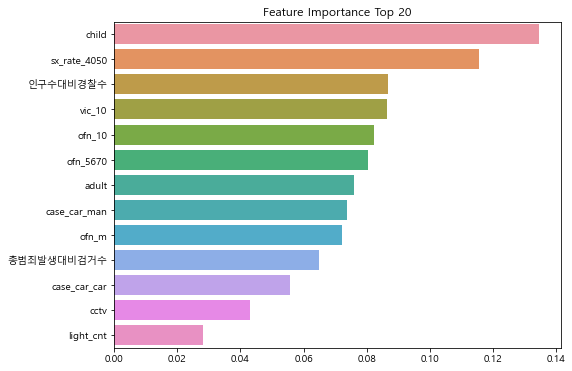

Index(['ofn_5670', 'child', '인구수대비경찰수', '총범죄발생대비검거수', 'cctv', 'light_cnt',
       'adult', 'ofn_m', 'vic_10', 'case_car_car', 'case_car_man', 'ofn_10',
       'sx_rate_4050'],
      dtype='object')


In [206]:
ft_importance_values = s3.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train_q3_t.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()
print(X_train_q3_t.columns)

In [205]:
mean_absolute_error(y_q3_test, pred3)

3.2098014087211792

In [131]:
y_q3_test

,q3
164,64.3
165,70.7
166,77.9
167,71.6
168,70.1
169,70.4
170,71.0
171,71.9
172,70.8
173,68.6


### Catboost로 돌려보기

In [117]:
from catboost import CatBoostClassifier

In [118]:
cat = CatBoostRegressor()

In [219]:
cv = KFold(n_splits = 6)
param_grid = {'n_estimators' : np.linspace(1, 100, 30),
             'depth' : [5,10,4,6,8],
             'learning_rate' : [0.01,0.03,0.1,1,10],
             'l2_leaf_reg' : [5,10,20,15]}
grid_search = GridSearchCV(CatBoostRegressor(),param_grid=param_grid, cv = cv, n_jobs = 4, scoring = 'neg_mean_absolute_error')
grid_fit = grid_search.fit(X_train_q3_t, y_q3_train)
#cat_q1_full = grid_search.best_estimator_
print('final params', grid_fit.best_params_)

0:	learn: 2.4791869	total: 12ms	remaining: 1.19s
1:	learn: 2.4681593	total: 16.3ms	remaining: 799ms
2:	learn: 2.4541378	total: 20.5ms	remaining: 663ms
3:	learn: 2.4401308	total: 25ms	remaining: 600ms
4:	learn: 2.4265128	total: 28ms	remaining: 532ms
5:	learn: 2.4157392	total: 31ms	remaining: 485ms
6:	learn: 2.4026678	total: 33.5ms	remaining: 445ms
7:	learn: 2.3915178	total: 35.8ms	remaining: 411ms
8:	learn: 2.3774728	total: 37.9ms	remaining: 383ms
9:	learn: 2.3652327	total: 39.5ms	remaining: 355ms
10:	learn: 2.3532323	total: 41ms	remaining: 332ms
11:	learn: 2.3403543	total: 42.6ms	remaining: 312ms
12:	learn: 2.3299335	total: 44.1ms	remaining: 295ms
13:	learn: 2.3202701	total: 45.5ms	remaining: 280ms
14:	learn: 2.3144334	total: 47.2ms	remaining: 268ms
15:	learn: 2.3078663	total: 48.7ms	remaining: 255ms
16:	learn: 2.2961656	total: 50ms	remaining: 244ms
17:	learn: 2.2836215	total: 51.4ms	remaining: 234ms
18:	learn: 2.2723113	total: 52.7ms	remaining: 225ms
19:	learn: 2.2631245	total: 53.7ms

In [215]:
# MAE 출력
mean_absolute_error(cat_q1_full.predict(X_test_q3_t),y_q3_test)

2.472906562592509

In [211]:
cat_q1_full_fi = pd.DataFrame(cat_q1_full.get_feature_importance(),index=X_q3_train.columns)
#cat_q1_full_fi.sort_values(by=0,ascending=False)

Learning rate set to 0.5
0:	learn: 2.2230993	total: 147ms	remaining: 0us


In [224]:
model_cat = CatBoostRegressor(
                             depth = 6,
                             learning_rate = 0.03,
                             l2_leaf_reg = 5,
                             n_estimators = 100)
fit_cat = model_cat.fit(X_train_q3_t,y_q3_train)
pred_cat = fit_cat.predict(X_test_q3_t)
mean_absolute_error(pred_cat, y_q3_test)

0:	learn: 2.4791869	total: 1.36ms	remaining: 135ms
1:	learn: 2.4681593	total: 2.72ms	remaining: 133ms
2:	learn: 2.4541378	total: 4.33ms	remaining: 140ms
3:	learn: 2.4401308	total: 5.52ms	remaining: 133ms
4:	learn: 2.4265128	total: 6.66ms	remaining: 127ms
5:	learn: 2.4157392	total: 7.83ms	remaining: 123ms
6:	learn: 2.4026678	total: 8.89ms	remaining: 118ms
7:	learn: 2.3915178	total: 10ms	remaining: 116ms
8:	learn: 2.3774728	total: 11.5ms	remaining: 117ms
9:	learn: 2.3652327	total: 12.8ms	remaining: 116ms
10:	learn: 2.3532323	total: 13.9ms	remaining: 113ms
11:	learn: 2.3403543	total: 14.8ms	remaining: 108ms
12:	learn: 2.3299335	total: 15.7ms	remaining: 105ms
13:	learn: 2.3202701	total: 16.7ms	remaining: 103ms
14:	learn: 2.3144334	total: 17.6ms	remaining: 100ms
15:	learn: 2.3078663	total: 18.6ms	remaining: 97.5ms
16:	learn: 2.2961656	total: 19.5ms	remaining: 95.4ms
17:	learn: 2.2836215	total: 20.6ms	remaining: 93.9ms
18:	learn: 2.2723113	total: 21.6ms	remaining: 91.9ms
19:	learn: 2.2631245

2.409777924782379

### Lasso

In [207]:
clfa = Lasso(alpha = 10, max_iter = 50)
lasso = clfa.fit(X_train_q3_t, y_q3_train)
lasso_y_hat = lasso.predict(X_test_q3_t)
mean_absolute_error(y_q3_test,lasso_y_hat)

2.530518495151408

In [128]:
param_grid = {'alpha' : [0.01,0.02,0.1,1,10,50,100],
              'max_iter' : [50,100,150],
             }

cv = KFold(n_splits = 6)

gcv = GridSearchCV(clf, param_grid = param_grid, cv = cv, n_jobs = 4)
gcv.fit(X_train_q3, y_q3_train)
print('final params', gcv.best_params_)
# print('best score: ', gcv.best_score_)

final params {'alpha': 100, 'max_iter': 50}


### Ridge

In [384]:
# temp = X_train_q1[['year']]
# temp_test = X_test_q1[['year']]

In [386]:
# standard = StandardScaler()
# X_train_q3 = pd.DataFrame(standard.fit_transform(X_train_q3.iloc[:,1:]), columns = X_train_q1.iloc[:,1:].columns)
# X_test_q3 = pd.DataFrame(standard.fit_transform(X_test_q3.iloc[:,1:]), columns = X_test_q1.iloc[:,1:].columns)

# #X_train_q3 = pd.concat([temp, paste_], axis = 1)
# #X_test_q3 = pd.concat([temp, paste2_], axis = 1)

In [235]:
rdg = Ridge()

In [477]:
# GridSearchCV로 좋은 성능 나타내는 파라미터 뽑기

param_grid = {'alpha' : [0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19],
              'max_iter' : [10,20,30,50],
             }

gcv = GridSearchCV(rdg, param_grid = param_grid, cv = 10, n_jobs = 4)
gcv.fit(X_train_q3_t, y_q3_train)
print('final params', gcv.best_params_)
# print('best score: ', gcv.best_score_)

final params {'alpha': 0.1, 'max_iter': 10}


In [459]:
# feature 선택
X_train_q3_t = X_train_q3[['인구수대비경찰수','총범죄발생대비검거수','mur_rob_cnt','인구수대비검거수','ofn_unknown','for_sx_rate_u20',
                          'ofn_m','vic_10','case_car_car','case_car_man','sx_rate_4050','ofn_10','교통사고범죄발생대비검거수','ofn_20'
                          ]]
X_test_q3_t = X_test_q3[['인구수대비경찰수','총범죄발생대비검거수','mur_rob_cnt','인구수대비검거수','ofn_unknown','for_sx_rate_u20',
                          'ofn_m','vic_10','case_car_car','case_car_man','sx_rate_4050','ofn_10','교통사고범죄발생대비검거수','ofn_20'
                        ]]

#'case_car_car','case_car_man','ofn_10','vic_10','ofn_20','ofn_340','ofn_m','인구수대비경찰수','sx_rate_4050'
#ofn_unknown, alpha 0.037

In [478]:
model_rdg42 = Ridge(alpha= 0.037,
                 max_iter = 10)
fit_rdg = model_rdg42.fit(X_train_q3_t, y_q3_train)
pred_rdg = fit_rdg.predict(X_test_q3_t)
mean_absolute_error(y_q3_test, pred_rdg)

1.8596644028342015

In [442]:
df.corr().sort_values(by = 'q3',ascending = False)[['q3']].drop(['q1','q2','q3','q4','q5'], axis = 0)

,q3
before_q5,0.309363
before_q2,0.305769
before_q1,0.285120
before_q4,0.278518
before_q3,0.276056
child,0.237613
총범죄발생대비검거수,0.193138
house,0.192864
인구수대비경찰수,0.178875
교통사고범죄발생대비검거수,0.161959


### Ridge- Q4

In [482]:
# GridSearchCV로 좋은 성능 나타내는 파라미터 뽑기

param_grid = {'alpha' : [0.1,0.01,0.03,0.04,0.2,0.3,0.4,0.02],
              'max_iter' : [10,20,30,50]
             }

gcv = GridSearchCV(rdg4, param_grid = param_grid, cv = 10, n_jobs = 4)
gcv.fit(X_train_q4, y_q4_train)
print('final params', gcv.best_params_)
# print('best score: ', gcv.best_score_)

final params {'alpha': 0.03, 'max_iter': 10}


In [480]:
rdg4 = Ridge()

In [493]:
# feature 선택
X_train_q4_t = X_train_q4[['before_q4','ofn_80ov','vio_cnt','cctv','ofn_m','car_cnt','sx_rate_o60','before_q5',
                          'house','bell']]
X_test_q4_t = X_test_q4[['before_q4','ofn_80ov','vio_cnt','cctv','ofn_m','car_cnt','sx_rate_o60','before_q5',
                          'house','bell']]

#'case_car_car','case_car_man','ofn_10','vic_10','ofn_20','ofn_340','ofn_m','인구수대비경찰수','sx_rate_4050'
#ofn_unknown, alpha 0.037

In [495]:
model_rdg49 = Ridge(alpha= 0.03,
                 max_iter = 10)
fit_rdg = model_rdg49.fit(X_train_q4_t, y_q4_train)
pred_rdg = fit_rdg.predict(X_test_q4_t)
mean_absolute_error(y_q4_test, pred_rdg)

2.2320629550588493

In [479]:
df.corr().sort_values(by = 'q4',ascending = False)[['q4']].drop(['q1','q2','q3','q4','q5'], axis = 0)

,q4
before_q4,0.645459
before_q5,0.605216
before_q2,0.555567
before_q1,0.537706
ofn_w,0.339240
child,0.314495
ofn_340,0.312174
before_q3,0.298328
총범죄발생대비검거수,0.287503
for_sx_rate_u20,0.259090
